# Twitter Sentiment Analysis

In [6]:
# DataFrame
import pandas as pd
import tensorflow as tf
# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [8]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [9]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

2022-05-05 15:58:25,218 : INFO : Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


2022-05-05 15:58:25,231 : INFO : Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.117.128.210:8470


2022-05-05 15:58:25,810 : INFO : Initializing the TPU system: grpc://10.117.128.210:8470


INFO:tensorflow:Finished initializing TPU system.


2022-05-05 15:58:34,148 : INFO : Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [14]:
!mkdir /root/.kaggle/
!mv ./kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [15]:
!kaggle datasets download -d kazanova/sentiment140

 67% 54.0M/80.9M [00:00<00:00, 186MB/s]
100% 80.9M/80.9M [00:00<00:00, 200MB/s]


In [16]:
!unzip sentiment140.zip -d .


Archive:  sentiment140.zip
  inflating: ./training.1600000.processed.noemoticon.csv  


In [17]:
# dataset_filename = os.listdir("./")[0]
# print(dataset_filename)
dataset_path ='./training.1600000.processed.noemoticon.csv'
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: ./training.1600000.processed.noemoticon.csv


In [18]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [19]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [20]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [21]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 511 ms, sys: 1.21 ms, total: 512 ms
Wall time: 521 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

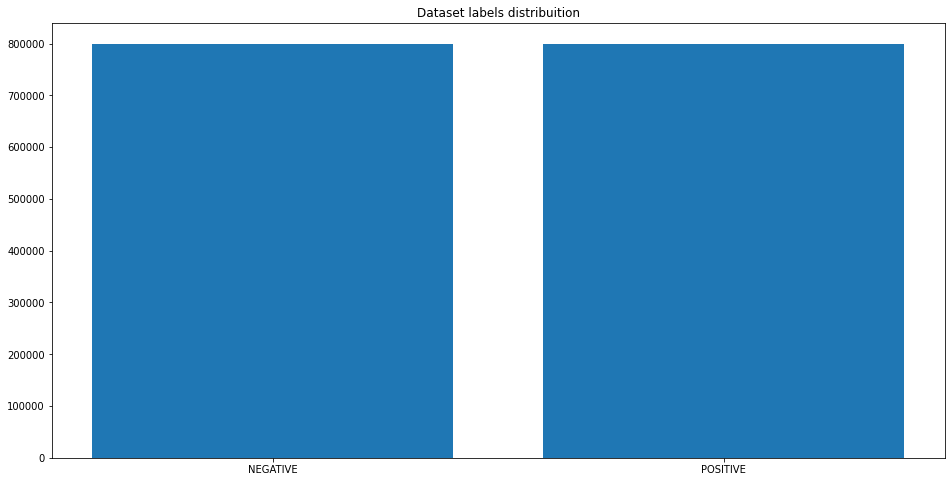

In [22]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [23]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [24]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [25]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1min 3s, sys: 399 ms, total: 1min 3s
Wall time: 1min 7s


### Split train and test

In [26]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [29]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 4.68 s, sys: 708 ms, total: 5.39 s
Wall time: 8 s


In [30]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

2022-05-05 16:01:55,122 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2022-05-05T16:01:55.122346', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}


In [31]:
w2v_model.build_vocab(documents)

2022-05-05 16:01:55,162 : INFO : collecting all words and their counts
2022-05-05 16:01:55,175 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-05-05 16:01:55,297 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2022-05-05 16:01:55,409 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2022-05-05 16:01:55,501 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2022-05-05 16:01:55,583 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2022-05-05 16:01:55,680 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2022-05-05 16:01:55,780 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2022-05-05 16:01:55,877 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2022-05-05 16:01:55,935 : INFO : PROGRESS: at s

In [33]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-05-05 16:02:29,664 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2022-05-05T16:02:29.664192', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'train'}
2022-05-05 16:02:30,840 : INFO : EPOCH 0 - PROGRESS: at 2.50% examples, 194112 words/s, in_qsize 14, out_qsize 1
2022-05-05 16:02:31,964 : INFO : EPOCH 0 - PROGRESS: at 5.00% examples, 187938 words/s, in_qsize 15, out_qsize 0
2022-05-05 16:02:33,129 : INFO : EPOCH 0 - PROGRESS: at 7.60% examples, 186465 words/s, in_qsize 15, out_qsize 0
2022-05-05 16:02:34,229 : INFO : EPOCH 0 - PROGRESS: at 9.77% examples, 180468 words/s, in_qsize 14, out_qsize 1
2022-05-05 16:02:35,412 : INFO : EPOCH 0 - PROGRESS: at 12.39% examples, 180526 words/s, in_qsize 15, out_qsize 5
2022-05-05 16:02:36,

CPU times: user 27min 15s, sys: 8.15 s, total: 27min 23s
Wall time: 14min 23s


(263124915, 295270528)

### Tokenize Text

In [35]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 20.9 s, sys: 251 ms, total: 21.2 s
Wall time: 21.2 s


In [36]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 27.6 s, sys: 1.25 s, total: 28.8 s
Wall time: 28.7 s


### Label Encoder 

In [37]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [38]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [39]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [40]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [41]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [42]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [43]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [44]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [45]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

### Train

In [46]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - ETA: 0s - loss: 0.5034 - accuracy: 0.7505WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-05-05 17:12:44,749 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 1931s 2s/step - loss: 0.5034 - accuracy: 0.7505 - val_loss: 0.4645 - val_accuracy: 0.7797 - lr: 0.0010
Epoch 2/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4780 - accuracy: 0.7679WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-05-05 17:44:20,040 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 1895s 2s/step - loss: 0.4780 - accuracy: 0.7679 - val_loss: 0.4574 - val_accuracy: 0.7849 - lr: 0.0010
Epoch 3/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4712 - accuracy: 0.7726WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-05-05 18:15:17,448 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 1857s 2s/step - loss: 0.4712 - accuracy: 0.7726 - val_loss: 0.4531 - val_accuracy: 0.7869 - lr: 0.0010
Epoch 4/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4671 - accuracy: 0.7745WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-05-05 18:45:43,557 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 1826s 2s/step - loss: 0.4671 - accuracy: 0.7745 - val_loss: 0.4516 - val_accuracy: 0.7882 - lr: 0.0010
Epoch 5/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4650 - accuracy: 0.7764WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-05-05 19:15:45,602 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 1802s 2s/step - loss: 0.4650 - accuracy: 0.7764 - val_loss: 0.4797 - val_accuracy: 0.7700 - lr: 0.0010
Epoch 6/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4639 - accuracy: 0.7772WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-05-05 19:45:22,245 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 1777s 2s/step - loss: 0.4639 - accuracy: 0.7772 - val_loss: 0.4493 - val_accuracy: 0.7891 - lr: 0.0010
Epoch 7/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.7780WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-05-05 20:14:25,636 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 1743s 2s/step - loss: 0.4620 - accuracy: 0.7780 - val_loss: 0.4481 - val_accuracy: 0.7902 - lr: 0.0010
Epoch 8/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4612 - accuracy: 0.7782WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-05-05 20:43:13,120 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 1727s 2s/step - loss: 0.4612 - accuracy: 0.7782 - val_loss: 0.4454 - val_accuracy: 0.7907 - lr: 0.0010
CPU times: user 2min 38s, sys: 33.5 s, total: 3min 11s
Wall time: 4h 3min 1s


### Evaluate

In [47]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 150s 479ms/step - loss: 0.4442 - accuracy: 0.7911

ACCURACY: 0.7910812497138977
LOSS: 0.44416025280952454
CPU times: user 4.26 s, sys: 1.65 s, total: 5.9 s
Wall time: 2min 35s


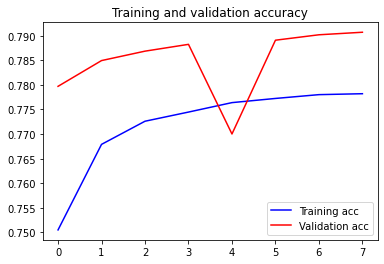

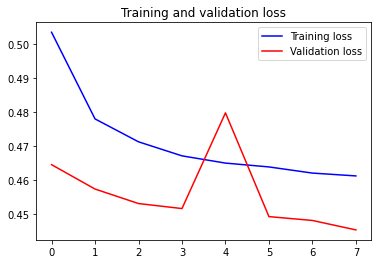

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [51]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [52]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [53]:
predict("I love the music")

{'elapsed_time': 0.41016340255737305,
 'label': 'POSITIVE',
 'score': 0.9756371974945068}

In [54]:
predict("I hate the rain")

{'elapsed_time': 0.10173869132995605,
 'label': 'NEGATIVE',
 'score': 0.012355595827102661}

In [55]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.11623907089233398,
 'label': 'NEGATIVE',
 'score': 0.27960580587387085}

### Confusion Matrix

In [56]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 132s 3s/step
CPU times: user 2.05 s, sys: 864 ms, total: 2.92 s
Wall time: 2min 17s


In [57]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

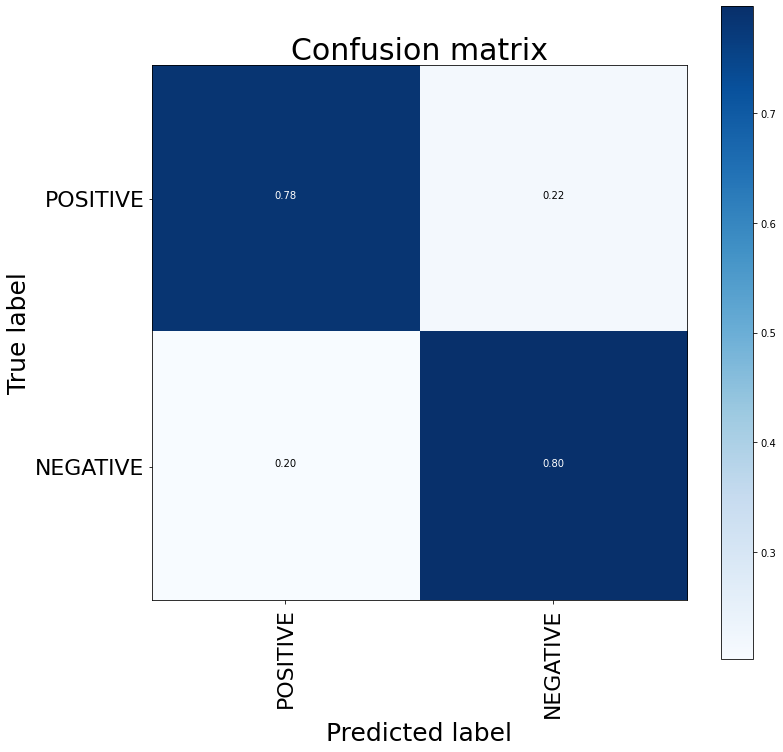

CPU times: user 1.48 s, sys: 52.1 ms, total: 1.53 s
Wall time: 1.53 s


In [58]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [59]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.78      0.79    159494
    POSITIVE       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



### Accuracy Score

In [60]:
accuracy_score(y_test_1d, y_pred_1d)

0.79108125

### Save model

In [75]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2022-05-05 21:09:03,052 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-05-05T21:09:03.052528', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2022-05-05 21:09:03,060 : INFO : not storing attribute cum_table
2022-05-05 21:09:03,288 : INFO : saved model.w2v
